### **Sentiment analysis for Movies**

Author: Rubén Cruz García

History: August 2020

-------------

This script performs a sentiment analysis to classify movie reviews from 3 webs.

The binary classification is initially done with 4 models.

After evaluating them, the best one is chosen to make the predictions.



In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from time import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve, f1_score

**Load the data**

In [23]:
# Amazon Data
input_file = './data/amazon_labelled.txt'
amazon = pd.read_csv(input_file, delimiter='\t', header=None)
amazon.columns = ['sentence', 'Class']

# Imdb Data
input_file = './data/imdb_labelled.txt'
imdb = pd.read_csv(input_file, delimiter='\t', header=None)
imdb.columns = ['sentence', 'Class']

# Yelp Data
input_file = './data/yelp_labelled.txt'
yelp = pd.read_csv(input_file, delimiter='\t', header=None)
yelp.columns = ['sentence', 'Class']

amazon.head()
# 1 --> Positive
# 0 --> Negative

,sentence,Class
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [24]:
# Combine data sets
together = pd.DataFrame()
together = pd.concat([amazon, imdb, yelp])

# Remove numbers
together['sentence'] = together['sentence'].replace('\d', '', regex=True)

# Remove punctuations and special chracters
together['sentence'] = together['sentence'].str.replace('[^\w\s]','')

print(together['Class'].value_counts())
print(together.shape)
together.head()

1    1386
0    1362
Name: Class, dtype: int64
(2748, 2)


,sentence,Class
0,So there is no way for me to plug it in here i...,0
1,Good case Excellent value,1
2,Great for the jawbone,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great,1


**Train and Test sets**

In [25]:
train_data, test_data = train_test_split(together, train_size=0.8,
                                         random_state=100, shuffle=True)
print(train_data.shape)
print(test_data.shape)
train_data.head()

(2198, 2)
(550, 2)


,sentence,Class
318,I want my money back,0
504,The waitress and manager are so friendly,1
567,Food was delicious,1
547,Despite the pans of reviewers I liked this mov...,1
339,putting the race card aside lets look at the m...,0


**Word Cloud with the most often negative words**

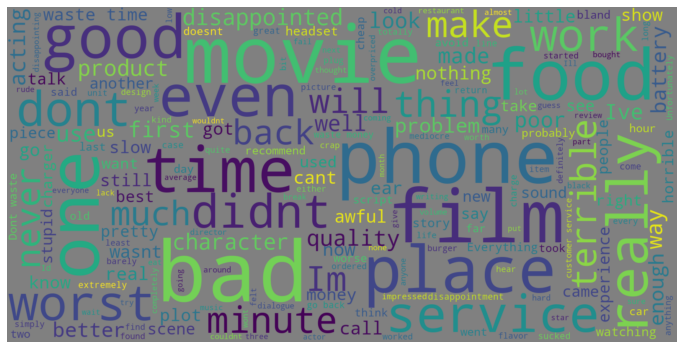

In [26]:
# This could lead to a side analysis
# to avoid wrong classification due to some words
# but it is out of scope

neg_phrases = train_data[train_data.Class == 0]
neg_words = []
for t in neg_phrases.sentence:
    neg_words.append(t)

neg_text = pd.Series(neg_words).str.cat(sep=' ')

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='grey', width=1600, height=800,
                      max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Processing. Tokenizer**

In [27]:
# CountVectorizer() converts 
# text documents to a matrix of token counts

# Unigram vectorizer, since bigram increases too much
# the sample, and the improvement is not significant
# (it actually penalizes the Logistic Regression, not shown)
vectorizer = CountVectorizer(ngram_range=(1, 1))

# Select the columns and prepare data for the models 
X_train = vectorizer.fit_transform(train_data['sentence'])
y_train = train_data['Class']

X_test = vectorizer.transform(test_data['sentence'])
y_test = test_data['Class']

# TF-IDF
# Weights the number of words 
# of each sentence: nr_words/total_words
# Also reduce the weight of common words
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf = tfidf_transformer.transform(X_test)

X_train_tfidf.shape

# A further analysis would include removing 
# a specific list of stop words

# Also trying different options: uni/bi-gram vectorizer
# or uni/bi-gram tf-idf for validation

(2198, 4678)

**Machine Learning Models**

In [28]:
# 4 different models
# (No hyperparameter tuning yet)

# Logistic Regression
t0 = time()
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
print('Elapsed time Logistic Regression: ', '%.3f'%(time() - t0) , 's')

# Naive Bayes
t0 = time()
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
print('Elapsed time Naive Bayes: ', '%.3f'%(time() - t0) , 's')

# Neural Network
t0 = time()
nn = MLPClassifier()
nn.fit(X_train_tfidf, y_train)
print('Elapsed time Neural Network: ', '%.3f'%(time() - t0) , 's')

# Support Vector Machine
t0 = time()
svm = SVC()
svm.fit(X_train_tfidf, y_train)
print('Elapsed time Support Vector Machine: ', '%.3f'%(time() - t0) , 's')

Elapsed time Logistic Regression:  0.044 s
Elapsed time Naive Bayes:  0.003 s
Elapsed time Neural Network:  16.464 s
Elapsed time Support Vector Machine:  0.748 s


### **Model performance**

**Validation**

In [29]:
models = {'Logistic Regression': lr, 'Naive Bayes': nb, 'Neural Network': nn,
          'SVM': svm}  
# 3-fold cross validation. Evaluated with the F1-score
# F1 score is the weighted average of precision and recall
# It takes into account both false positive and false negatives

for m in models: 
  score = cross_val_score(models[m], X_train_tfidf, y_train, cv=3, scoring='f1')
  print(m, '\n', 'F1 mean score: ', '%.3f'%score.mean(), '\n', '='*25)

Logistic Regression 
 F1 mean score:  0.790 
Naive Bayes 
 F1 mean score:  0.799 
Neural Network 
 F1 mean score:  0.778 
SVM 
 F1 mean score:  0.805 


**Evaluate the 4 models on test data**


In [30]:
# Define a dataframe for evaluation
df2 = test_data.copy()

df2['Logistic Regression'] = lr.predict(X_test)
df2['Naive Bayes'] = nb.predict(X_test)
df2['SVM'] = svm.predict(X_test)
df2['Neural Network'] = nn.predict(X_test)
df2.tail()

,sentence,Class,Logistic Regression,Naive Bayes,SVM,Neural Network
42,It was too predictable even for a chick flick,0,0,0,0,0
474,Total letdown I would much rather just go to t...,0,1,0,0,1
345,However after seeing the short again after abo...,1,0,0,0,0
53,The directing seems too pretentious,0,1,1,0,0
345,Pretty good beer selection too,1,1,1,0,1


**Classification report (Precision, Accuracy, Recall, F1-Score)**

In [31]:
for ml in models:
  cl_report = classification_report(y_test, df2[ml], labels=[1, 0]) 
  print(ml, '\n', cl_report, '\n', '='*50)

Logistic Regression 
               precision    recall  f1-score   support

           1       0.73      0.87      0.79       278
           0       0.84      0.66      0.74       272

    accuracy                           0.77       550
   macro avg       0.78      0.77      0.77       550
weighted avg       0.78      0.77      0.77       550
 
Naive Bayes 
               precision    recall  f1-score   support

           1       0.85      0.81      0.83       278
           0       0.82      0.85      0.83       272

    accuracy                           0.83       550
   macro avg       0.83      0.83      0.83       550
weighted avg       0.83      0.83      0.83       550
 
Neural Network 
               precision    recall  f1-score   support

           1       0.82      0.83      0.83       278
           0       0.83      0.82      0.82       272

    accuracy                           0.82       550
   macro avg       0.82      0.82      0.82       550
weighted avg       

**Confusion Matrices**

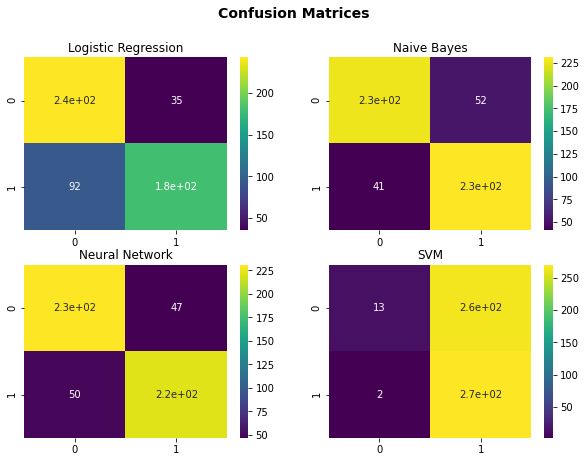

In [32]:
fig1 = plt.figure(figsize=(10, 7))
fig1.suptitle('Confusion Matrices', fontsize=14, fontweight='bold')

i = 0
for ml in models:
  cm = confusion_matrix(y_test, df2[ml], labels=[1, 0])
  ax = fig1.add_subplot(2, 2, 1 + i)
  plt.title(ml)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  im = sns.heatmap(cm, annot=True, cmap="viridis", cbar=True)
  i = i + 1
plt.show()

**ROC Curve**

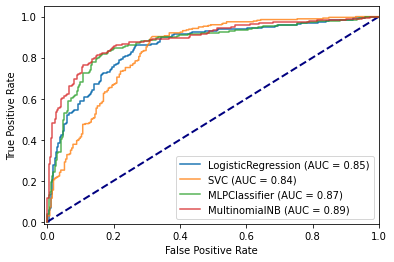

In [33]:
lr_disp = plot_roc_curve(lr, X_test, y_test)
ax = plt.gca()
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
svm_disp = plot_roc_curve(svm, X_test, y_test, ax=ax, alpha=0.8)
nn_disp = plot_roc_curve(nn, X_test, y_test, ax=ax, alpha=0.8)
nb_disp = plot_roc_curve(nb, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

**Model selection**

The SVM shows a very bad confusion matrix, with many predicted positive reviews,
which are actually negative. In other words: the F1-score for positive comments is very low. Besides this, the precision for negative class is only 0.5.

The Logistic Regression has the lowest accuracy for positive comments and its ROC is one of the worst among all models.

The Neural Network tends to perform slightly worse than Naive Bayes on most of the classification report scores, including its ROC, which is marginally worse than Naive Bayes. Moreover, the Neural Network takes very long to run, so other libraries/tuning would be needed if we want to select it.

For these reasons, we choose the Naive Bayes classifier.

**Cross Validation for tuning parameters**

In [34]:
# Set different options to be tested by GridSearchCV
parameters = {'alpha': np.linspace(0.5, 1.5, 10), 'fit_prior':[True, False]}

nb_tuned = MultinomialNB()
clf = GridSearchCV(nb_tuned, parameters, cv=3, scoring='f1')
grid_fit = clf.fit(X_train_tfidf, y_train)

print("Best Parameters: ", clf.best_params_)

best_nb = grid_fit.best_estimator_
best_nb.fit(X_train_tfidf, y_train)

# Make predictions using the new model
best_train_predictions = best_nb.predict(X_train_tfidf)
best_test_predictions_nopro = best_nb.predict(X_test)
best_test_predictions = best_nb.predict(X_test_tfidf)

# Calculate the f1_score of the new model
print('Training F1-Score: ', '%.3f'%f1_score(best_train_predictions, y_train))
print('Testing F1-Score (no preproccesing): ', '%.3f'%f1_score(best_test_predictions_nopro, y_test))
print('Testing F1-Score (with preproccesing): ', '%.3f'%f1_score(best_test_predictions, y_test))

Best Parameters:  {'alpha': 1.2777777777777777, 'fit_prior': False}
Training F1-Score:  0.947
Testing F1-Score (no preproccesing):  0.828
Testing F1-Score (with preproccesing):  0.830


Still we could improve the F1-score of the model by preprocessing data more in deep and by using lexicon models like Textblob or pre-trained language model such as ULMFiT.